# ARIMA model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf

## Data download and preparation

In [2]:
prediction_length = 10
end_date = datetime.today()
start_date = end_date - timedelta(days=365)  
apple_stock_price = yf.download("AAPL", start=start_date, end=end_date, interval="1d")["Adj Close"]

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Load your time series data
# Assuming the data is in a CSV file with a date column and a value column

apple_stock_price = apple_stock_price.reset_index()
apple_stock_price.columns = ['ds', 'y']

df = apple_stock_price

## Statistical tests

### Automated Dickey Fuller Test (ADF)

Used to determine "d" part of the ARIMA model

In [4]:
def adf(x):
    res = adfuller(x)
    print("Test-Statistic:", res[0])
    print("P-Value:", res[1])
    if res[1] < 0.05:
      s = "stationary"
    else:
      s = "non_stationary"
    print(s)
    return (s)

In [5]:
df = apple_stock_price

In [6]:

d = 0

for i in range(5):
    s = adf(df['y'])
    if s == "stationary":
        print("_____")
        print(f"order is {i}")
        d = i
        break
    print("-------")
    df = df.diff().dropna()


Test-Statistic: -1.3143090287048624
P-Value: 0.6226007558561066
non_stationary
-------
Test-Statistic: -14.204478311377253
P-Value: 1.7645659569516577e-26
stationary
_____
order is 1


In [8]:
df_diff = df
df = apple_stock_price

### Autocorrelation function (ACF) and Partial Autocorrelation Function (PACF)

ACF is used to determine "q" for me MA part of the ARIMA model. If the ACF plot shows significant correlations at lag q and cuts off sharply after lag q, it indicates that an MA(q) model may be appropriate.

PACF is used to determine "p" for the AR part of the model. If the PACF plot shows significant partial correlations at lag p and cuts off sharply after lag p, it suggests that an AR(p) model may be appropriate.

In [12]:
nlags = 50

C:\Users\topco\AppData\Local\Temp\ipykernel_19296\2928263429.py:5: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax[0].stem(range(len(acf_vals)), acf_vals, use_line_collection=True)
C:\Users\topco\AppData\Local\Temp\ipykernel_19296\2928263429.py:7: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax[1].stem(range(len(pacf_vals)), pacf_vals, use_line_collection=True)


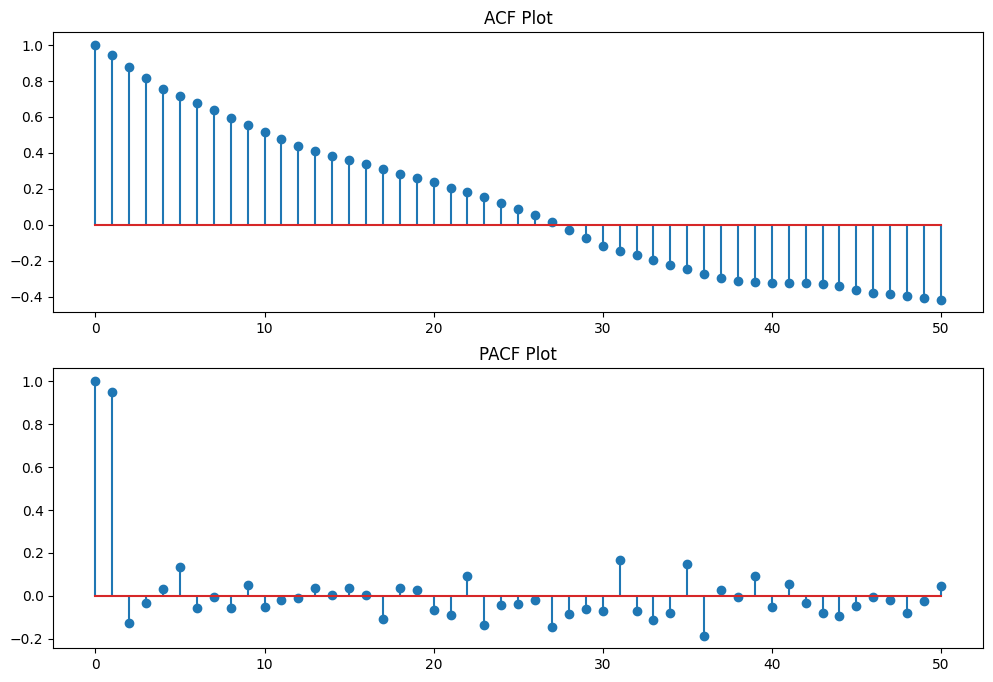

In [13]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, figsize=(12, 8))
acf_vals = acf(df_diff["y"], nlags=nlags)
pacf_vals = pacf(df_diff["y"], nlags=nlags)
ax[0].stem(range(len(acf_vals)), acf_vals, use_line_collection=True)
ax[0].set_title('ACF Plot')
ax[1].stem(range(len(pacf_vals)), pacf_vals, use_line_collection=True)
ax[1].set_title('PACF Plot')
plt.show()

In [14]:
def find_optimal_order(acf_vals, pacf_vals, confidence_interval=0.05):
    # Calculate the confidence intervals
    confidence_threshold = 1.96 / (len(df_diff)**0.5)

    # Find the optimal q value from ACF
    for i in range(1, len(acf_vals)):
        if abs(acf_vals[i]) < confidence_threshold:
            q = i - 1
            break
    else:
        q = len(acf_vals) - 1

    # Find the optimal p value from PACF
    for i in range(1, len(pacf_vals)):
        if abs(pacf_vals[i]) < confidence_threshold:
            p = i - 1
            break
    else:
        p = len(pacf_vals) - 1

    return p, q

p, q = find_optimal_order(acf_vals, pacf_vals)
print(f'Optimal p: {p}, Optimal q: {q}')

Optimal p: 2, Optimal q: 23


Mean Squared Error: 157.70526959631513


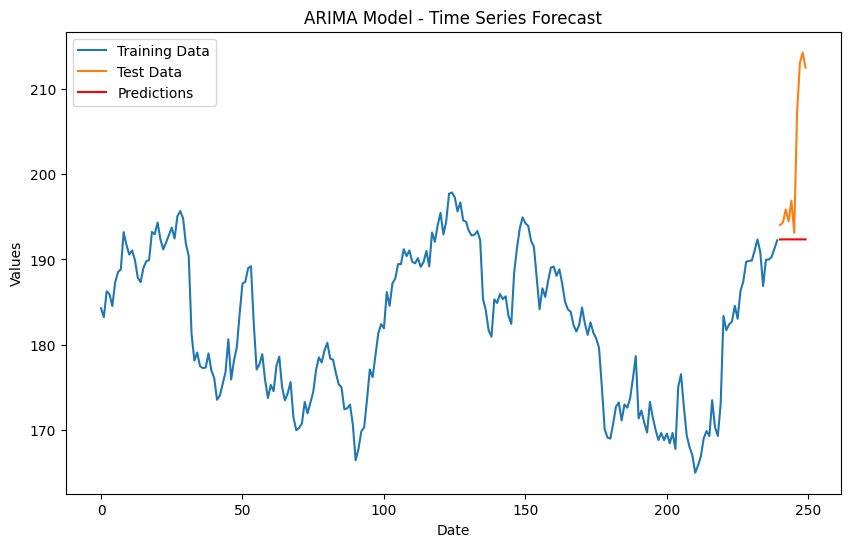

In [19]:
# Based on ACF and PACF plots, determine p and q
# Typically, p is the lag value where PACF crosses the confidence interval for the first time
# Typically, q is the lag value where ACF crosses the confidence interval for the first time
p = 1  # Example value based on PACF plot
d = 1  # Since we differenced the data
q = 1  # Example value based on ACF plot

# Split the data into train and test sets
train_size = int(len(df) - prediction_length)
train, test = df[:train_size]["y"], df[train_size:]["y"]

# Fit an ARIMA model
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))
predictions = pd.Series(predictions, index=test.index)

# Evaluate the model
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(predictions, label='Predictions', color='red')
plt.legend()
plt.title('ARIMA Model - Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Values')
plt.show()